In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Bijection between covariance matrix and vectors

In [25]:
# Create the bijection
tfb = tfp.bijectors
bij = tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular()])

# Simple example
cov_mat = np.linalg.cholesky([[1, 0.5],
                              [0.5, 1]])

print("Initial cov mat: ")
print(cov_mat)

#bijector inverse : cov_matrix_cholesky -----> vector
cov_mat_vectorized = bij.inverse(cov_mat)
print("Vector: " ) 
print(cov_mat_vectorized)

#bijector forward : vector -----> cov_matrix_cholesky
cholesky = bij.forward(cov_mat_vectorized)
print("Final cov mat: " )
print(cholesky)

#Original covariance matrix thanks to cholesky factorization :
np.matmul(cholesky, np.transpose(cholesky))

Initial cov mat: 
[[1.        0.       ]
 [0.5       0.8660254]]
Vector: 
[0.32022865 0.5        0.54132485]
Final cov mat: 
[[1.        0.       ]
 [0.5       0.8660254]]


array([[1. , 0.5],
       [0.5, 1. ]])

# Auxiliary Functions

In [49]:
def sample_from_NIW(mu_n, lam_n, phi_n, nu_n):
    """
    Sample from a NIW given its parameters
    First we sample the precision matrix, then we use it to sample the mean vector
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=nu_n, scale_tril=chol).sample()
    cov = np.linalg.inv(prec)
    mu = tfd.MultivariateNormalFullCovariance(mu_n, cov/(lam_n)).sample()
    return mu, cov

def evaluate_NIW_log(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, lam_n, phi_n, nu_n ) ]
    L = Normal Inverse Wishart
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).log_prob(x_mu)
    return f1 + f2

def compute_beta_log(mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
    
    # Target distribution terms
    num = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)

    return num  - den

def sample_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector):
    """
    Sample new mean and covariance matrix through the bijection
    """
    mu = tfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample()
    
    chol = np.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = tfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample()
    cov_sampl = bijector.forward(vec_sampl)
    cov = np.matmul(cov_sampl , np.transpose(cov_sampl))

    return mu,cov


def MH_Step(mu_old, cov_old, cov_prop_mu, cov_prop_cov,bijector):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW(mu_0,lam_0,phi_0,nu_0)
    """
    
    mu_0 = np.array([0,0])
    lam_0 = 0.1
    phi_0 = np.eye(2)
    nu_0 = 3

    # Sample the proposal using a centered Normal Wishart
    mu,cov = sample_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector)

    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_log(mu, cov, mu_0, lam_0, phi_0, nu_0, mu_old, cov_old)
    
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    # Accept/Reject step
    draw = tfd.Uniform().sample()
    if(np.log(draw) > beta):
        #Rejection
        return mu_old,cov_old,accept_rate
    else:
        #Accept
        return mu,cov,accept_rate
        


# Checking MH convergence to Normal Inverse Wishart Distribution



In [50]:
#Run a Metropolis Hastings algorithm to sample from the target density : NormalInverseWishart(mu_0, lam_0, phi_0, nu_0)

#Parameters of the NormalInverseWishart
mu_0 = np.array([0,0])
lam_0 = 0.1
phi_0 = np.eye(2)
nu_0 = 3

#Ranom Walk Metropolis Hastings covariance matrix for mu and cov
cov_prop_mu = np.eye(2) #covariance matrix for the mean sampling
cov_prop_cov = np.eye(3) #covariance matrix for the vectorized covariance matrix sampling

#Collect the values of the mean and covariance during the sampling to plot the traceplot
sampled_mu_0_MH = []
sampled_mu_1_MH = []
sampled_cov_0_MH = []
sampled_mu_0 = []
sampled_mu_1 = []
sampled_cov_0 = []

#Start of the chain
mu_MH = np.array([0,0])
cov_MH = np.eye(2)

#Collection of acceptance rates:
acc_rate_cum = []

for i in range(1500):
    
    
    mu_MH, cov_MH , acc_rate = MH_Step(mu_MH,cov_MH,cov_prop_mu,cov_prop_cov,bij)
    acc_rate_cum.append(acc_rate)
    
    
    if(i > 500 and i % 5 == 0 ):
        print("Accept rate:" + str(np.mean(acc_rate_cum)))
        
        sampled_mu_0_MH.append(mu_MH[0])
        sampled_mu_1_MH.append(mu_MH[1])
        sampled_cov_0_MH.append(cov_MH[0,0])
        
        #Sample from true distribution
        mu,cov = sample_from_NIW(mu_0, lam_0, phi_0, nu_0)

        sampled_mu_0.append(mu[0])
        sampled_mu_1.append(mu[1])
        sampled_cov_0.append(cov[0,0])




Accept rate:8.702291623183449e-06
Accept rate:0.25530487296395576
Accept rate:0.17020324911374718
Accept rate:0.13580370362218402
Accept rate:0.30864296289774723
Accept rate:0.26512571377368077
Accept rate:0.22725061180601228
Accept rate:0.3238442853302608
Accept rate:0.28786158696023184
Accept rate:0.3590754282642087
Accept rate:0.331777133771167
Accept rate:0.38746237262356975
Accept rate:0.3601867060381511
Accept rate:0.3344795695051686
Accept rate:0.3649481472417769
Accept rate:0.40051024983739303
Accept rate:0.3821408461748919
Accept rate:0.36654767146513584
Accept rate:0.3998872677038129
Accept rate:0.39887481696371674
Accept rate:0.42749982567973027
Accept rate:0.44925491754588104
Accept rate:0.46846934911615573
Accept rate:0.49061645956964917
Accept rate:0.4935507069031875
Accept rate:0.4745752426079102
Accept rate:0.4940354188076172
Accept rate:0.5121055824216308
Accept rate:0.5289295278553677
Accept rate:0.536964931997959
Accept rate:0.5483943904489016
Accept rate:0.557670556

Accept rate:0.7525809944762867
Accept rate:0.7532251382891412
Accept rate:0.7541138190653034
Accept rate:0.7550278940873655
Accept rate:0.7552994873379167
Accept rate:0.7559199992877735
Accept rate:0.7567057502513411
Accept rate:0.7572684591973777
Accept rate:0.7580040176081274
Accept rate:0.7582566714432536
Accept rate:0.7591325530684593
Accept rate:0.7600021106386092
Accept rate:0.7608654123989019
Accept rate:0.7617225256161102
Accept rate:0.7625735165960527
Accept rate:0.7633469196262274
Accept rate:0.763753896024558
Accept rate:0.764107301805602
Accept rate:0.7649379098978358
Accept rate:0.7657626891613522
Accept rate:0.7663582148359677
Accept rate:0.7666606905217666
Accept rate:0.7673770818585605
Accept rate:0.7681820054507453
Accept rate:0.7674459360086952
Accept rate:0.7679658433192835
Accept rate:0.7687604808421626
Accept rate:0.7676446195320143
Accept rate:0.7683019937803419
Accept rate:0.7683057968559686
Accept rate:0.7690885475422662
Accept rate:0.7689456502355111
Accept rat

Accept rate:0.8095068073047519
Accept rate:0.8098642054148742
Accept rate:0.8102202649552959
Accept rate:0.8093104997809157
Accept rate:0.8078276299380146
Accept rate:0.8079050409218163
Accept rate:0.8082620947490992
Accept rate:0.8086178237013272
Accept rate:0.8086695339092723
Accept rate:0.8090231946599021
Accept rate:0.8093696706837942
Accept rate:0.8097207394302329
Accept rate:0.8100705174827508
Accept rate:0.8104190119460852
Accept rate:0.8107662298729239
Accept rate:0.8111121782643811
Accept rate:0.8110532090429323
Accept rate:0.8108814745084651
Accept rate:0.8112253263729953
Accept rate:0.8115679301363836
Accept rate:0.8119092925817888
Accept rate:0.8117850771318389
Accept rate:0.8121248152597598
Accept rate:0.8123939821585493
Accept rate:0.8122838362574619
Accept rate:0.8125169409336603
Accept rate:0.8126859075664553
Accept rate:0.81302099538834
Accept rate:0.8129220203904433
Accept rate:0.813015763443959
Accept rate:0.8133484756086494
Accept rate:0.8135488870728422
Accept rate

Accept rate:0.8463731280822314
Accept rate:0.8465151165153226
Accept rate:0.8467069726196784
Accept rate:0.8468983496825753
Accept rate:0.8470892494959386
Accept rate:0.8470741075076076
Accept rate:0.8472643138415533
Accept rate:0.8473131747020464
Accept rate:0.8472876280108003
Accept rate:0.8473438036089344
Accept rate:0.847532734545062
Accept rate:0.8477211984084179
Accept rate:0.8479091969289013
Accept rate:0.8480421224024528
Accept rate:0.8482292626457996
Accept rate:0.8482710826118154
Accept rate:0.8483535448398769
Accept rate:0.8483198729867852
Accept rate:0.8484130728725583
Accept rate:0.848598613787035
Accept rate:0.848783701056244
Accept rate:0.8486933289178685
Accept rate:0.8487611856844984
Accept rate:0.8489453986130191
Accept rate:0.8489324470739215
Accept rate:0.8491160042463711
Accept rate:0.849255741993043
Accept rate:0.8494140012406214
Accept rate:0.8495963087451727
Accept rate:0.8497277165410991
Accept rate:0.8499092048061462
Accept rate:0.8499157529412491
Accept rate:

Accept rate:0.8575173483708901
Accept rate:0.8576508841268687
Accept rate:0.8574064337291132
Accept rate:0.8572778918970432
Accept rate:0.8566623492547937
Accept rate:0.8567961845962925
Accept rate:0.85692977024499
Accept rate:0.8570631068990021
Accept rate:0.8565538555335374
Accept rate:0.8566872938074596
Accept rate:0.856782645910229
Accept rate:0.8569156239548805
Accept rate:0.8567616526019427
Accept rate:0.8568033300185037
Accept rate:0.8568303414761588
Accept rate:0.8569627833434333
Accept rate:0.8570949804013415
Accept rate:0.8571879784177795
Accept rate:0.8572691075477963
Accept rate:0.8573474483957607
Accept rate:0.8573315556927489
Accept rate:0.8573185043078732
Accept rate:0.8574496453884726
Accept rate:0.8575805456222756
Accept rate:0.8575115319250867
Accept rate:0.8576421354705266
Accept rate:0.8577231663461663
Accept rate:0.8577175578156578
Accept rate:0.8578099151128973
Accept rate:0.8578937595497955
Accept rate:0.8579562971947648
Accept rate:0.8580710968165448
Accept rate

Accept rate:0.8432193157250759
Accept rate:0.8431262436872897
Accept rate:0.8431356993063958
Accept rate:0.843166828556982
Accept rate:0.8432840431843683
Accept rate:0.8432537307060701
Accept rate:0.8432407216712283
Accept rate:0.8432588042076745
Accept rate:0.8433541071981847
Accept rate:0.843434919992652
Accept rate:0.8433082280629324
Accept rate:0.8433015062157122
Accept rate:0.8434179241159977
Accept rate:0.8435341691611974
Accept rate:0.8436502417360037
Accept rate:0.8437148215025465
Accept rate:0.8436498214810106
Accept rate:0.8435827249220321
Accept rate:0.8436984181728295
Accept rate:0.8437472989155489
Accept rate:0.8438595206711508
Accept rate:0.8439747534972237
Accept rate:0.8437967852722497
Accept rate:0.8439118944945988
Accept rate:0.8439159732629113
Accept rate:0.8437630387397007
Accept rate:0.8436058465826629
Accept rate:0.8432911084213703
Accept rate:0.8426819825918307
Accept rate:0.8427974030007875
Accept rate:0.8427906349398234
Accept rate:0.8427016416621945
Accept rat

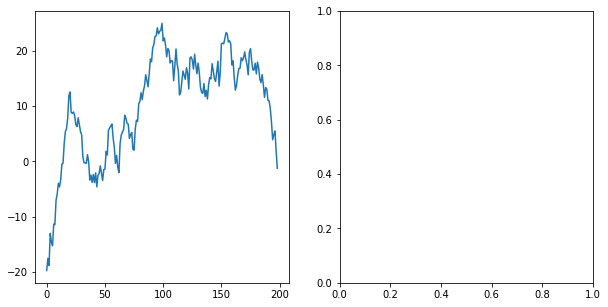

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(np.arange(len(sampled_mu_0_MH)), sampled_mu_0_MH)